## Import Data

In [18]:
!ls .././data | sort

busstops_norway.csv
grunnkrets_age_distribution.csv
grunnkrets_households_num_persons.csv
grunnkrets_income_households.csv
grunnkrets_norway_stripped.csv
plaace_hierarchy.csv
sample_submission.csv
stores_extra.csv
stores_test.csv
stores_train.csv


## Libraries

In [201]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing

## Settings

In [204]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
plt.figure(figsize=(9, 7))
plt.style.use('bmh')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}

plt.rc('font', **font)

<Figure size 900x700 with 0 Axes>

## Import Files

In [170]:
stores_train = pd.read_csv('../data/stores_train.csv')
stores_test = pd.read_csv('../data/stores_test.csv')
stores_extra = pd.read_csv('../data/stores_extra.csv')
plaace_hierarchy = pd.read_csv('../data/plaace_hierarchy.csv')
grunnkrets = pd.read_csv('../data/grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('../data/grunnkrets_age_distribution.csv')
grunnkrets_household_types = pd.read_csv('../data/grunnkrets_households_num_persons.csv')
grunnkrets_household_income = pd.read_csv('../data/grunnkrets_income_households.csv')
busstops = pd.read_csv('../data/busstops_norway.csv')

## RMSLE Function

In [171]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

# Merging all the Datasets

## Merging plaace_hierarchy with Stores data

In [172]:
# Augment stores_train with information about the hierarchy
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
stores_with_hierarchy_test = stores_test.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

# Show dataframe, but transposed so that we can more easily see all the resulting columns
stores_with_hierarchy.head()

store_id  year                           store_name  \
0   983540538-974187930-44774  2016  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755  2016           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491  2016                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912  2016        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469  2016             BURGER KING TILLERTORGET   

  plaace_hierarchy_id   sales_channel_name_x  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue   sales_channel_name_y  lv1                lv1_desc  lv2  \
0   17.998  Hamburger restaurants    1  Dining and Experiences  1.1   
1   23.828  Hamburger restaurants    1  Dining and Experiences  1.1   
2   16.099  Hamburger restaurants    1  Dining and Experiences  1.1   
3    9.296  Hamburger restaurants    1  Dining and Experiences  1.1   
4    4.528  Hamburger restaurants    1  Dining and Experiences  1.1   

     lv2_desc    lv3               lv3_desc      lv4               lv4_desc  
0  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
1  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
2  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
3  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants  
4  Restaurant  1.1.1  Hamburger restaurants  1.1.1.0  Hamburger restaurants

## Merging Grunnkrets with Stores data

In [173]:
grunnkrets_2016 = grunnkrets.loc[grunnkrets['year'] == 2016]
stores_with_hierarchy_grunnkrets = pd.merge(stores_with_hierarchy, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test = pd.merge(stores_with_hierarchy_test, grunnkrets_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_test


store_id  year_x                    store_name  \
0     914206820-914239427-717245    2016     VÅLERENGA HALAL BURGER AS   
1     916789157-916823770-824309    2016             BURGER KING MYREN   
2       913341082-977479363-2948    2016           BURGER KING STOVNER   
3      889682582-889697172-28720    2016       BURGER KING TUNGASLETTA   
4     997991699-998006945-417222    2016              VULKAN BURGERBAR   
...                          ...     ...                           ...   
8572  917323003-917383529-844309    2016            GULATING HAUGESUND   
8573  917353379-917411824-845904    2016             STAVANGER BEER AS   
8574  917072302-917089248-833647    2016      GULATING ØLUTSALG OG PUB   
8575  916960557-916993161-829908    2016     VI BRYGGER BUTIKKDRIFT AS   
8576   987280891-972040746-45320    2016  KROKEN ØL OG MINERALVANN ANS   

     plaace_hierarchy_id   sales_channel_name_x  grunnkrets_id  \
0                1.1.1.0  Hamburger restaurants        3012704   
1                1.1.1.0  Hamburger restaurants        8061401   
2                1.1.1.0  Hamburger restaurants        3013917   
3                1.1.1.0  Hamburger restaurants       16012104   
4                1.1.1.0  Hamburger restaurants        3014305   
...                  ...                    ...            ...   
8572            2.8.11.2     Beer and soda shop       11490601   
8573            2.8.11.2     Beer and soda shop       11030901   
8574            2.8.11.2     Beer and soda shop        2270103   
8575            2.8.11.2     Beer and soda shop       12470701   
8576            2.8.11.2     Beer and soda shop        8170207   

                     address        lat        lon        chain_name  \
0           STRØMSVEIEN 25 A  59.908672  10.787031               NaN   
1                    MYREN 1  59.201467   9.588243       BURGER KING   
2           STOVNER SENTER 3  59.962146  10.924524       BURGER KING   
3             TUNGASLETTA 16  63.420785  10.461091       BURGER KING   
4     AUD SCHØNEMANNS VEI 15  59.921102  10.785123  VULKAN BURGERBAR   
...                      ...        ...        ...               ...   
8572           BRÅTAVEGEN 30  59.259575   5.325813  GULATING GRUPPEN   
8573              SANDVIGÅ 7  58.976219   5.721546               NaN   
8574          GARDERBAKKEN 6  59.928330  11.163202  GULATING GRUPPEN   
8575          RAVNANGERVEGEN  60.445790   5.161587               NaN   
8576                     NaN  59.097903   9.055490               NaN   

           mall_name   sales_channel_name_y  lv1                lv1_desc  lv2  \
0                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
1                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
2     Stovner Senter  Hamburger restaurants    1  Dining and Experiences  1.1   
3                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
4                NaN  Hamburger restaurants    1  Dining and Experiences  1.1   
...              ...                    ...  ...                     ...  ...   
8572             NaN     Beer and soda shop    2                  Retail  2.8   
8573             NaN     Beer and soda shop    2                  Retail  2.8   
8574             NaN     Beer and soda shop    2                  Retail  2.8   
8575             NaN     Beer and soda shop    2                  Retail  2.8   
8576             NaN     Beer and soda shop    2                  Retail  2.8   

             lv2_desc     lv3               lv3_desc       lv4  \
0          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
2          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
3          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
4          Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
...               ...     ...                    ...       ...   
8572  Food and drinks  2.8.11          Alc

In [174]:
grunnkrets_ages
grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age

# Feature engineering: Age binning
under_18 = grunnkrets_ages.loc[: , "age_0":"age_18"]
above_18 = grunnkrets_ages.loc[: , "age_19":"age_90"]
grunnkrets_ages['0_to_18'] = under_18.sum(axis = 1)
grunnkrets_ages['19_to_90'] = above_18.sum(axis = 1)
grunnkrets_ages = grunnkrets_ages.drop(grunnkrets_ages.iloc[:, 2:93],axis = 1) # drop age columns

grunnkrets_ages_2016 = grunnkrets_ages.loc[grunnkrets_ages['year'] == 2016]
stores_with_hierarchy_grunnkrets_age = pd.merge(stores_with_hierarchy_grunnkrets, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_test = pd.merge(stores_with_hierarchy_grunnkrets_test, grunnkrets_ages_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age['0_to_18'] = stores_with_hierarchy_grunnkrets_age['0_to_18'].fillna((stores_with_hierarchy_grunnkrets_age['0_to_18'].mean()))
stores_with_hierarchy_grunnkrets_age['19_to_90'] = stores_with_hierarchy_grunnkrets_age['19_to_90'].fillna((stores_with_hierarchy_grunnkrets_age['19_to_90'].mean()))


In [175]:
grunnkrets_household_types
grunnkrets_household_types_2016 = grunnkrets_household_types.loc[grunnkrets_household_types['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes = pd.merge(stores_with_hierarchy_grunnkrets_age, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_test = pd.merge(stores_with_hierarchy_grunnkrets_age_test, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes


/tmp/ipykernel_940718/2204752244.py:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  stores_with_hierarchy_grunnkrets_age_hhtypes = pd.merge(stores_with_hierarchy_grunnkrets_age, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')
/tmp/ipykernel_940718/2204752244.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'year_x'} in the result is deprecated and will raise a MergeError in a future version.
  stores_with_hierarchy_grunnkrets_age_hhtypes_test = pd.merge(stores_with_hierarchy_grunnkrets_age_test, grunnkrets_household_types_2016, how='left', on='grunnkrets_id')


store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

In [176]:
grunnkrets_household_income
grunnkrets_household_income_2016 = grunnkrets_household_income.loc[grunnkrets_household_income['year'] == 2016]
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')
stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test = pd.merge(stores_with_hierarchy_grunnkrets_age_hhtypes_test, grunnkrets_household_income_2016, how='left', on='grunnkrets_id')

stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome


store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

In [177]:
stores_train_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome
stores_test_merged = stores_with_hierarchy_grunnkrets_age_hhtypes_hhincome_test
stores_train_merged

store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

# Exploratory Data Analysis

In [178]:
df = stores_train_merged
df


store_id  year_x  \
0       983540538-974187930-44774    2016   
1       987074191-973117734-44755    2016   
2       984890265-981157303-64491    2016   
3      914057442-992924179-126912    2016   
4      913018583-913063538-668469    2016   
...                           ...     ...   
12854  915789943-915806929-781991    2016   
12855  917921733-917982368-868081    2016   
12856  911721961-911764474-496764    2016   
12857  914337046-914343372-721294    2016   
12858  917494436-917551936-851089    2016   

                                store_name plaace_hierarchy_id  \
0      MCDONALD'S BRAGERNES TORG MAGASINET             1.1.1.0   
1               MCDONALD'S KLINGENBERGGATA             1.1.1.0   
2                     BURGER KING HØNEFOSS             1.1.1.0   
3            BURGER KING GLASSHUSPASSASJEN             1.1.1.0   
4                 BURGER KING TILLERTORGET             1.1.1.0   
...                                    ...                 ...   
12854          MEIERIGÅRDEN BRYGGERIUTSALG            2.8.11.2   
12855          GULATING ØLUTSALG CC GJØVIK            2.8.11.2   
12856           GULATING ØLUTSALG STRØMMEN            2.8.11.2   
12857                       DET GODE BRYGG            2.8.11.2   
12858             TROMSØ BRYGGERIUTSALG AS            2.8.11.2   

        sales_channel_name_x  grunnkrets_id            address        lat  \
0      Hamburger restaurants        6020303  BRAGERNES TORG 13  59.743104   
1      Hamburger restaurants        3010306                NaN  59.913759   
2      Hamburger restaurants        6050102  KONG RINGS GATE 1  60.164751   
3      Hamburger restaurants       18040102        STORGATA 12  67.283669   
4      Hamburger restaurants       16017414                NaN  63.358068   
...                      ...            ...                ...        ...   
12854     Beer and soda shop        7010705         THUEGATA 2  59.416276   
12855     Beer and soda shop        5020406                NaN  60.799991   
12856     Beer and soda shop        2310803     STØPERIVEIEN 6  59.946562   
12857     Beer and soda shop       11020113        VÅGSGATA 16  58.850261   
12858     Beer and soda shop       19021302     PLANETVEGEN 10  69.670422   

             lon        chain_name            mall_name  revenue  \
0      10.204928         MCDONALDS    Magasinet Drammen   17.998   
1      10.734031         MCDONALDS                  NaN   23.828   
2      10.254656       BURGER KING       Kuben Hønefoss   16.099   
3      14.379796       BURGER KING    Glasshuspassasjen    9.296   
4      10.374832       BURGER KING         Tillertorget    4.528   
...          ...               ...                  ...      ...   
12854  10.480970               NaN                  NaN    0.088   
12855  10.693635  GULATING GRUPPEN            CC Gjøvik    1.816   
12856  11.007659  GULATING GRUPPEN  Strømmen Storsenter   38.225   
12857   5.735674               NaN          Bystasjonen    3.642   
12858  19.042659               NaN                  NaN    2.328   

        sales_channel_name_y  lv1                lv1_desc  lv2  \
0      Hamburger restaurants    1  Dining and Experiences  1.1   
1      Hamburger restaurants    1  Dining and Experiences  1.1   
2      Hamburger restaurants    1  Dining and Experiences  1.1   
3      Hamburger restaurants    1  Dining and Experiences  1.1   
4      Hamburger restaurants    1  Dining and Experiences  1.1   
...                      ...  ...                     ...  ...   
12854     Beer and soda shop    2                  Retail  2.8   
12855     Beer and soda shop    2                  Retail  2.8   
12856     Beer and soda shop    2                  Retail  2.8   
12857     Beer and soda shop    2                  Retail  2.8   
12858     Beer and soda shop    2                  Retail  2.8   

              lv2_desc     lv3               lv3_desc       lv4  \
0           Restaurant   1.1.1  Hamburger restaurants   1.1.1.0   
1           Restaurant

In [179]:
# Ignore first
# s = df.pop('revenue') 
# new_df = pd.concat([df, s], 1)
# new_df
new_df = df


### Seperate the data set into numerical and categorical data

In [180]:
df_numerical_features = new_df.select_dtypes(exclude='object')
df_categorical_features = new_df.select_dtypes(include='object')
df_numerical_features

year_x  grunnkrets_id        lat        lon  revenue  lv1  lv2  year_y  \
0        2016        6020303  59.743104  10.204928   17.998    1  1.1  2016.0   
1        2016        3010306  59.913759  10.734031   23.828    1  1.1  2016.0   
2        2016        6050102  60.164751  10.254656   16.099    1  1.1  2016.0   
3        2016       18040102  67.283669  14.379796    9.296    1  1.1  2016.0   
4        2016       16017414  63.358068  10.374832    4.528    1  1.1  2016.0   
...       ...            ...        ...        ...      ...  ...  ...     ...   
12854    2016        7010705  59.416276  10.480970    0.088    2  2.8  2016.0   
12855    2016        5020406  60.799991  10.693635    1.816    2  2.8  2016.0   
12856    2016        2310803  59.946562  11.007659   38.225    2  2.8  2016.0   
12857    2016       11020113  58.850261   5.735674    3.642    2  2.8  2016.0   
12858    2016       19021302  69.670422  19.042659    2.328    2  2.8  2016.0   

       area_km2  year_x     0_to_18     19_to_90  year_y  \
0      0.155779  2016.0   25.000000   132.000000  2016.0   
1      0.264278     NaN  143.178518   622.172205  2016.0   
2      0.160152  2016.0   67.000000   305.000000  2016.0   
3      0.095029  2016.0   46.000000   428.000000  2016.0   
4      0.251070     NaN  143.178518   622.172205  2016.0   
...         ...     ...         ...          ...     ...   
12854  0.291337  2016.0  194.000000  1322.000000  2016.0   
12855  0.137188  2016.0   42.000000   461.000000  2016.0   
12856  0.123431  2016.0  145.000000   972.000000  2016.0   
12857  0.034857  2016.0   22.000000   259.000000  2016.0   
12858  0.204915  2016.0  238.000000   912.000000  2016.0   

       couple_children_0_to_5_years  couple_children_18_or_above  \
0                              20.0                          0.0   
1                               0.0                          0.0   
2                              45.0                          9.0   
3                              41.0                         10.0   
4                               0.0                          0.0   
...                             ...                          ...   
12854                         159.0                         53.0   
12855                          47.0                          9.0   
12856                         147.0                         30.0   
12857                          22.0                          0.0   
12858                         255.0                         47.0   

       couple_children_6_to_17_years  couple_without_children_x  \
0                                8.0                       28.0   
1                                0.0                        0.0   
2                               38.0                       84.0   
3                               27.0                      126.0   
4                                0.0                        0.0   
...                              ...                        ...   
12854                          113.0                      488.0   
12855                           14.0                      138.0   
12856                           76.0                      332.0   
12857                            7.0                       86.0   
12858                          135.0                      270.0   

       single_parent_children_0_to_5_years  \
0                                      4.0   
1                                      0.0   
2                                     13.0   
3                                     11.0   
4                                      0.0   
...                                    ...   
12854                                 46.0   
12855                                  5.0   
12856                                 50.0   
12857                                  6.0   
12858                                 10.0   

       single_parent_children_18_or_above  \
0                                     6.0   
1                                     0.0   
2  

## Distribution of Revenue

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


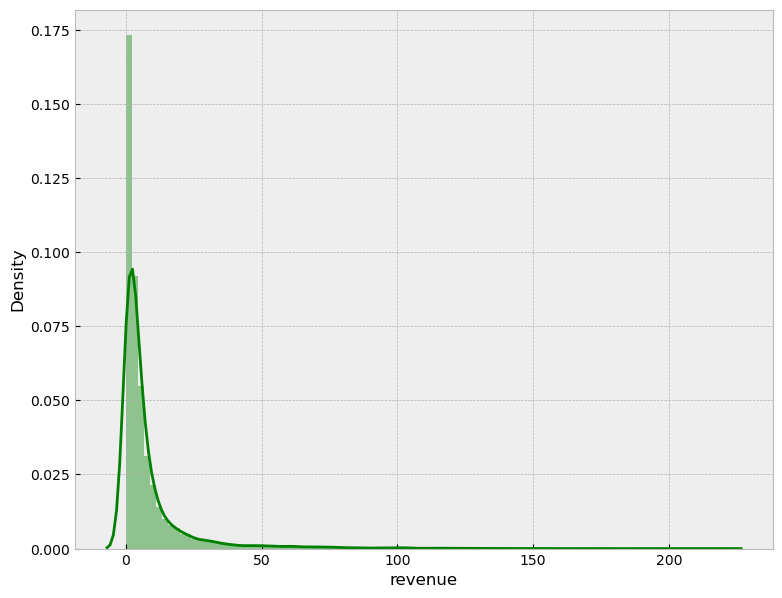

In [181]:
plt.figure(figsize=(9, 7))
sns.distplot(df['revenue'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical Data Distribution

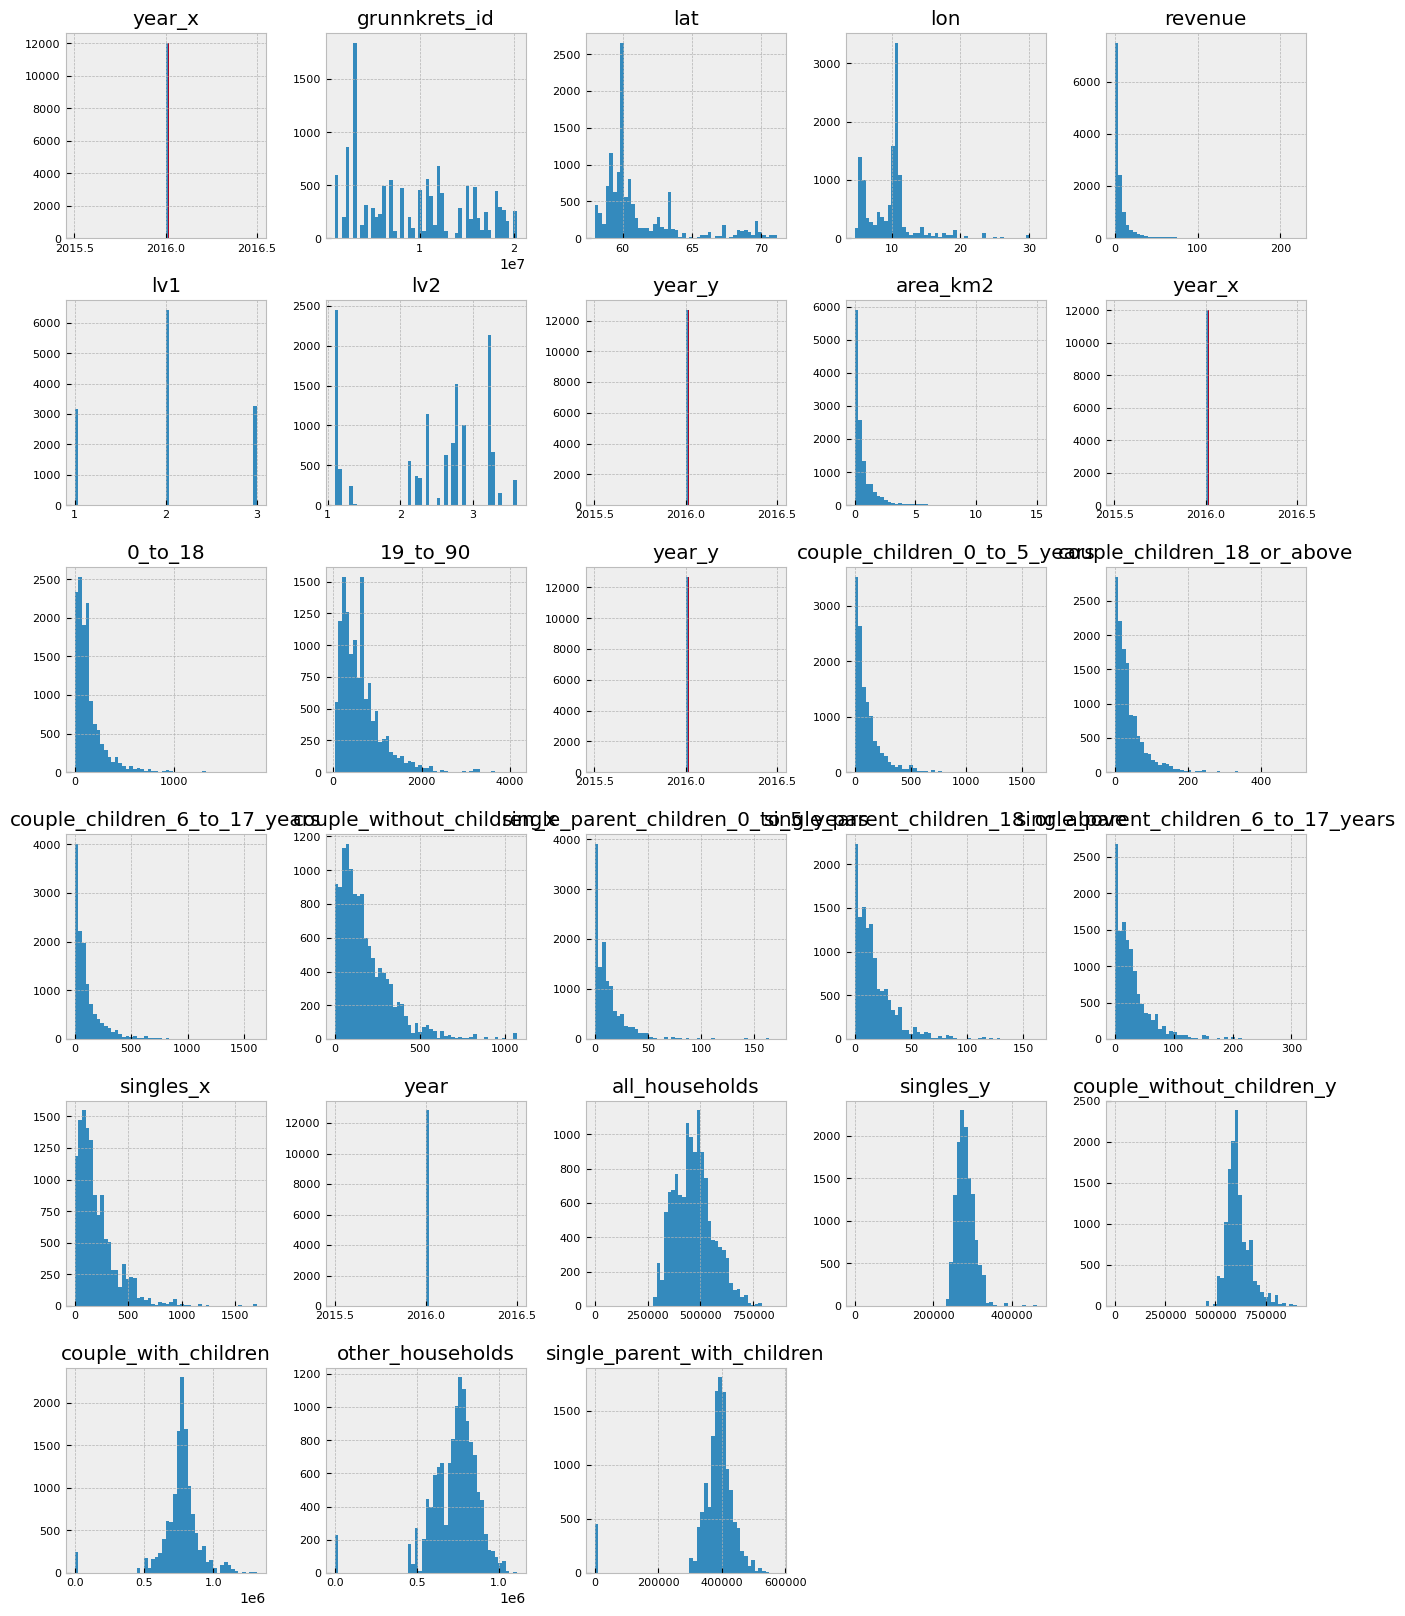

In [182]:
df_numerical_features.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); 

## Correlation with Revenue

In [183]:
df_num_corr = df_numerical_features.corr()['revenue'][:-1] # -1 because the latest row is SalePrice
df_num_corr
golden_features_list = df_num_corr[abs(df_num_corr) > 0.00].sort_values(ascending=False)
print("The top {} correlated values with revenue are:\n{}".format(len(golden_features_list), golden_features_list))

The top 22 correlated values with revenue are:
revenue                                 1.000000
all_households                          0.037117
singles_y                               0.034573
lv2                                     0.021941
0_to_18                                 0.021079
other_households                        0.020773
couple_children_6_to_17_years           0.016798
couple_with_children                    0.014701
grunnkrets_id                           0.014588
area_km2                                0.013703
couple_children_0_to_5_years            0.012815
couple_without_children_y               0.012283
couple_children_18_or_above             0.011553
single_parent_children_18_or_above      0.011551
single_parent_children_6_to_17_years    0.008844
lat                                     0.007547
19_to_90                                0.004041
lon                                     0.003112
single_parent_children_0_to_5_years     0.000775
couple_without_childre

# Feature Engineering

## 1. Dropping Redundant Columns

In [184]:
stores_train_finalcols = stores_train_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry'])

stores_test_finalcols = stores_test_merged.drop(columns=[
    'year_x', 'store_name', 'plaace_hierarchy_id', 'grunnkrets_id', 'address', 'lv1', 'lv2', 'lv3', 'lv4', 'year_y',
    'grunnkrets_name', 'district_name', 'geometry'])

## 2. One Hot Encoding - Do not need to run this part anymore for LightGBM & CatBoost

### Using LabelEncoder

In [71]:
#categorical data
label_encoder = preprocessing.LabelEncoder()
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

store_id  sales_channel_name_x        lat        lon  \
0      983540538-974187930-44774                    39  59.743104  10.204928   
1      987074191-973117734-44755                    39  59.913759  10.734031   
2      984890265-981157303-64491                    39  60.164751  10.254656   
3     914057442-992924179-126912                    39  67.283669  14.379796   
4     913018583-913063538-668469                    39  63.358068  10.374832   
...                          ...                   ...        ...        ...   
8572  917323003-917383529-844309                     5  59.259575   5.325813   
8573  917353379-917411824-845904                     5  58.976219   5.721546   
8574  917072302-917089248-833647                     5  59.928330  11.163202   
8575  916960557-916993161-829908                     5  60.445790   5.161587   
8576   987280891-972040746-45320                     5  59.097903   9.055490   

            chain_name          mall_name  revenue   sales_channel_name_y  \
0            MCDONALDS  Magasinet Drammen   17.998  Hamburger restaurants   
1            MCDONALDS                NaN   23.828  Hamburger restaurants   
2          BURGER KING     Kuben Hønefoss   16.099  Hamburger restaurants   
3          BURGER KING  Glasshuspassasjen    9.296  Hamburger restaurants   
4          BURGER KING       Tillertorget    4.528  Hamburger restaurants   
...                ...                ...      ...                    ...   
8572  GULATING GRUPPEN                NaN      NaN     Beer and soda shop   
8573               NaN                NaN      NaN     Beer and soda shop   
8574  GULATING GRUPPEN                NaN      NaN     Beer and soda shop   
8575               NaN                NaN      NaN     Beer and soda shop   
8576               NaN                NaN      NaN     Beer and soda shop   

                    lv1_desc         lv2_desc               lv3_desc  \
0     Dining and Experiences       Restaurant  Hamburger restaurants   
1     Dining and Experiences       Restaurant  Hamburger restaurants   
2     Dining and Experiences       Restaurant  Hamburger restaurants   
3     Dining and Experiences       Restaurant  Hamburger restaurants   
4     Dining and Experiences       Restaurant  Hamburger restaurants   
...                      ...              ...                    ...   
8572                  Retail  Food and drinks          Alcohol sales   
8573                  Retail  Food and drinks          Alcohol sales   
8574                  Retail  Food and drinks          Alcohol sales   
8575                  Retail  Food and drinks          Alcohol sales   
8576                  Retail  Food and drinks          Alcohol sales   

                   lv4_desc municipality_name  area_km2     0_to_18  \
0     Hamburger restaurants           Drammen  0.155779   25.000000   
1     Hamburger restaurants              Oslo  0.264278  143.178518   
2     Hamburger restaurants         Ringerike  0.160152   67.000000   
3     Hamburger restaurants              Bodø  0.095029   46.000000   
4     Hamburger restaurants         Trondheim  0.251070  143.178518   
...                     ...               ...       ...         ...   
8572     Beer and soda shop            Karmøy  1.708924   92.000000   
8573     Beer and soda shop         Stavanger  0.310575   90.000000   
8574     Beer and soda shop               Fet  1.627789  237.000000   
8575     Beer and soda shop             Askøy  1.103012  231.000000   
8576     Beer and soda shop         Drangedal  1.677433  299.000000   

         19_to_90  couple_children_0_to_5_years  couple_children_18_or_above  \
0      132.000000                          20.0                          0.0   
1      622.172205                           0.0                          0.0   
2      305.000000                          45.0                          9.0   
3      428.000000                          41.0                         10.0   
4      622.172205   

### Using Get_Dummies

In [141]:
#categorical data
categorical_cols = ['sales_channel_name_x', 'chain_name', 'municipality_name', 'sales_channel_name_y', 'lv1_desc',
'lv2_desc', 'lv3_desc', 'lv4_desc','mall_name'] 

df_res = stores_train_finalcols.append(stores_test_finalcols)

#import pandas as pd
df_res_onehot = pd.get_dummies(df_res, columns = categorical_cols)
stores_train_finalcols_onehot = df_res_onehot.iloc[:12859]
stores_test_finalcols_onehot = df_res_onehot.iloc[12859:]

stores_test_finalcols_onehot

store_id        lat        lon  revenue  area_km2  \
2448  951635200-897514982-167862  59.802559   5.819865      NaN  1.082595   
2449   992480939-992524235-98502  58.941515   5.745594      NaN  0.358485   
2450   916749686-974106361-40966  59.687080   9.629682      NaN  0.293455   
2451  995992574-971996641-130780  60.202481   5.447288      NaN  0.901113   
2452  997985613-998000475-427101  59.696582   8.065247      NaN  2.299577   
...                          ...        ...        ...      ...       ...   
8572  917323003-917383529-844309  59.259575   5.325813      NaN  1.708924   
8573  917353379-917411824-845904  58.976219   5.721546      NaN  0.310575   
8574  917072302-917089248-833647  59.928330  11.163202      NaN  1.627789   
8575  916960557-916993161-829908  60.445790   5.161587      NaN  1.103012   
8576   987280891-972040746-45320  59.097903   9.055490      NaN  1.677433   

      0_to_18  19_to_90  couple_children_0_to_5_years  \
2448    100.0     291.0                          67.0   
2449    266.0    1335.0                         229.0   
2450    156.0     722.0                         125.0   
2451    309.0     921.0                         289.0   
2452    125.0     477.0                         102.0   
...       ...       ...                           ...   
8572     92.0     336.0                          56.0   
8573     90.0     929.0                         102.0   
8574    237.0    1050.0                         200.0   
8575    231.0     683.0                         202.0   
8576    299.0    1003.0                         233.0   

      couple_children_18_or_above  couple_children_6_to_17_years  \
2448                         35.0                          106.0   
2449                        103.0                          229.0   
2450                         31.0                          124.0   
2451                         88.0                          208.0   
2452                         73.0                          127.0   
...                           ...                            ...   
8572                         23.0                          115.0   
8573                         12.0                           47.0   
8574                         84.0                          222.0   
8575                        101.0                          207.0   
8576                         75.0                          249.0   

      couple_without_children_x  single_parent_children_0_to_5_years  \
2448                      100.0                                  5.0   
2449                      382.0                                 15.0   
2450                      166.0                                 14.0   
2451                      276.0                                 27.0   
2452                       94.0                                  0.0   
...                         ...                                  ...   
8572                      120.0                                  7.0   
8573                      352.0                                 14.0   
8574                      316.0                                 13.0   
8575                      178.0                                 16.0   
8576                      274.0                                 29.0   

      single_parent_children_18_or_above  \
2448                                 0.0   
2449                                29.0   
2450                                23.0   
2451                                38.0   
2452                                17.0   
...                                  ...   
8572                                16.0   
8573                                 8.0   
8574                                46.0   
8575                                40.0   
8576                                32.0   

      single_parent_children_6_to_17_years  singles_x    year  all_households  \
2448                                  10.0       64.0  2016.0        585200.0   
2449                                  51.

## 3. Handling Outliers

In [158]:
#Dropping the outlier rows with Percentiles - Run this if you are using One Hot Encoder
# upper_lim = stores_train_finalcols_onehot['revenue'].quantile(.95)
# lower_lim = stores_train_finalcols_onehot['revenue'].quantile(.05)

# stores_train_finalcols_onehot = stores_train_finalcols_onehot[(stores_train_finalcols_onehot['revenue'] < upper_lim) & (stores_train_finalcols_onehot['revenue'] > lower_lim)]
# X_train = stores_train_finalcols_onehot.drop(columns=['revenue', 'store_id'])
# y_train = stores_train_finalcols_onehot.revenue 
# X_test = stores_test_finalcols_onehot.drop(columns=['store_id'])
# X_train


In [212]:
#Dropping the outlier rows with Percentiles - Run this if NOT using One Hot Encoder
upper_lim = stores_train_finalcols['revenue'].quantile(.95)
lower_lim = stores_train_finalcols['revenue'].quantile(.05)

stores_train_finalcols = stores_train_finalcols[(stores_train_finalcols['revenue'] < upper_lim) & (stores_train_finalcols['revenue'] > lower_lim)]
X_train = stores_train_finalcols.drop(columns=['revenue', 'store_id'])
y_train = stores_train_finalcols.revenue 
X_test = stores_test_finalcols.drop(columns=['store_id'])

#Imputing missing values for both train and test
X_train.fillna(-999, inplace=True)
X_test.fillna(-999,inplace=True)

categorical_features_indices = np.where(X_train.dtypes != np.float)[0]
categorical_features_indices

/tmp/ipykernel_940718/3404883441.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X_train.dtypes != np.float)[0]


array([ 0,  3,  4,  5,  6,  7,  8,  9, 10])

# Models

## Model 1 - catBoost

### Log Revenue Value to Match Loss Function RMSE

In [213]:
y_train_log = np.log(y_train)
y_train_log

0        2.890261
2        2.778757
3        2.229584
4        1.510280
5        2.486572
           ...   
12852    0.064851
12853    1.049772
12855    0.596636
12857    1.292533
12858    0.845010
Name: revenue, Length: 10411, dtype: float64

### Do Internal Split

In [214]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train, train_size=0.9, random_state=123)

In [188]:
import catboost as ctb

In [189]:
best_params = {
            'bagging_temperature': 0.5,
            'depth': 8,
            'iterations': 1000,
            'l2_leaf_reg': 25,
            'learning_rate': 0.05,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2
    }
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, cat_features=categorical_features_indices)

TBB Warning: The number of workers is currently limited to 3. The request for 7 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



### Parameter Tuning Using GridSearch

In [192]:
from sklearn.model_selection import GridSearchCV

train_dataset = ctb.Pool(X_training, y_training, cat_features=categorical_features_indices) 
model = ctb.CatBoostRegressor()

#create the grid
grid = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100],
        'l2_leaf_reg': [0.5]}
search_results = model.grid_search(grid, train_dataset, cv=5)
print("\nBest Params : ", search_results['params'])

0:	learn: 1.6185456	test: 1.5980454	best: 1.5980454 (0)	total: 3.35ms	remaining: 97.1ms
1:	learn: 1.6100121	test: 1.5897911	best: 1.5897911 (1)	total: 6.6ms	remaining: 92.4ms
2:	learn: 1.6016755	test: 1.5817965	best: 1.5817965 (2)	total: 9.57ms	remaining: 86.2ms
3:	learn: 1.5933728	test: 1.5737496	best: 1.5737496 (3)	total: 13.6ms	remaining: 88.6ms
4:	learn: 1.5850374	test: 1.5654701	best: 1.5654701 (4)	total: 16.7ms	remaining: 83.7ms
5:	learn: 1.5771813	test: 1.5578652	best: 1.5578652 (5)	total: 17.9ms	remaining: 71.5ms
6:	learn: 1.5693111	test: 1.5502776	best: 1.5502776 (6)	total: 21ms	remaining: 68.9ms
7:	learn: 1.5612899	test: 1.5424363	best: 1.5424363 (7)	total: 23.9ms	remaining: 65.8ms
8:	learn: 1.5535152	test: 1.5349272	best: 1.5349272 (8)	total: 26.8ms	remaining: 62.6ms
9:	learn: 1.5460220	test: 1.5276455	best: 1.5276455 (9)	total: 29.1ms	remaining: 58.1ms
10:	learn: 1.5386464	test: 1.5205445	best: 1.5205445 (10)	total: 30.5ms	remaining: 52.8ms
11:	learn: 1.5310675	test: 1.5131

### Using the parameters from GridSearch

In [193]:
best_params = {'depth': 8, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 0.5}
model = ctb.CatBoostRegressor(**best_params,
                               loss_function='RMSE',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               verbose=False)
model.fit(X_training, y_training, cat_features=categorical_features_indices)

In [194]:
y_train_pred = model.predict(X_training)
y_train_pred[y_train_pred<0] = 0
y_train_pred

#Added
y_test_pred = model.predict(X_testing)
y_test_pred[y_test_pred<0] = 0
y_test_pred

array([2.09376957, 2.56994246, 0.6692212 , ..., 0.76187843, 0.42135212,
       0.85033798])

### Reverse log the predictions

In [195]:
y_training = np.exp(y_training)
y_testing = np.exp(y_testing)
y_train_pred = np.exp(y_train_pred)
y_test_pred = np.exp(y_test_pred)

In [196]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.5959
Test set RMSLE: 0.6607


### Predict for X_test

In [197]:
y_test_pred = model.predict(X_test) 
y_test_pred

array([1.05260881, 1.58656241, 0.75050751, ..., 0.91563539, 0.71167741,
       0.89029241])

In [198]:
y_test_pred_original_values = np.exp(y_test_pred)

### Save Predictions

In [199]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_test_pred_original_values)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_14.csv', index=False)
submission

id  predicted
0     914206820-914239427-717245   2.865116
1     916789157-916823770-824309   4.886921
2       913341082-977479363-2948   2.118075
3      889682582-889697172-28720   4.748909
4     997991699-998006945-417222   7.454923
...                          ...        ...
8572  917323003-917383529-844309   1.911461
8573  917353379-917411824-845904   2.842290
8574  917072302-917089248-833647   2.498362
8575  916960557-916993161-829908   2.037406
8576   987280891-972040746-45320   2.435842

[8577 rows x 2 columns]

### Feature Importance

In [205]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(200, 200))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'Feature Importance')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


## Model 2 - XGBoost

In [206]:
import xgboost as xg

In [ ]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
pred = xgb_r.predict(X_test)

In [ ]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols_onehot.store_id 
submission['predicted'] = np.asarray(pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_6.csv', index=False)
submission

## Model 3 - LightGBM

In [208]:
import lightgbm as lgb

In [215]:
# Added internal split
from sklearn.model_selection import train_test_split
X_training, X_testing, y_training, y_testing = train_test_split(X_train, y_train, train_size=0.9, random_state=123)

In [217]:
# X_training, X_testing, y_training, y_testing
# X_test
y_testing

8651      4.762
9097      4.030
5018      0.653
4371      0.587
4872     17.377
          ...  
5036      6.967
5702      4.752
7035     15.657
5763      9.397
12652     0.588
Name: revenue, Length: 1042, dtype: float64

### Transform categorical features into the appropriate type that is expected by LightGBM.

In [218]:
for c in X_training.columns:
    col_type = X_training[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_training[c] = X_training[c].astype('category')

for c in X_testing.columns:
    col_type = X_testing[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_testing[c] = X_testing[c].astype('category')

for c in X_test.columns:
    col_type = X_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X_test[c] = X_test[c].astype('category')

/tmp/ipykernel_940718/2152689381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_training[c] = X_training[c].astype('category')
/tmp/ipykernel_940718/2152689381.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_testing[c] = X_testing[c].astype('category')


In [219]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [220]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_training, y_training)
lgb_eval = lgb.Dataset(X_testing, y_testing, reference=lgb_train)

In [221]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l1: 2.76745	valid_0's l2: 13.5393


/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/lhome/tbfiora/.local/lib/python3.10/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [224]:
y_train_pred = gbm.predict(X_training, num_iteration=gbm.best_iteration)
y_test_pred = gbm.predict(X_testing, num_iteration=gbm.best_iteration)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [225]:
y_pred

array([5.06129161, 7.86470303, 6.09196628, ..., 6.11361056, 4.30811014,
       3.95665463])

In [226]:
print(f'Train set RMSLE: {rmsle(y_training, y_train_pred) :.4f}')
print(f'Test set RMSLE: {rmsle(y_testing, y_test_pred) :.4f}')

Train set RMSLE: 0.6220
Test set RMSLE: 0.6525


In [227]:
submission = pd.DataFrame()
submission['id'] = stores_test_finalcols.store_id 
submission['predicted'] = np.asarray(y_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_21.csv', index=False)
submission

id  predicted
0     914206820-914239427-717245   5.061292
1     916789157-916823770-824309   7.864703
2       913341082-977479363-2948   6.091966
3      889682582-889697172-28720   7.812610
4     997991699-998006945-417222   6.852076
...                          ...        ...
8572  917323003-917383529-844309   6.291849
8573  917353379-917411824-845904   5.248304
8574  917072302-917089248-833647   6.113611
8575  916960557-916993161-829908   4.308110
8576   987280891-972040746-45320   3.956655

[8577 rows x 2 columns]